## Expirementation with XGBoost to detect Automatically Generated Domains <b>
ML Model to detect Domain Generation Algorithm (DGA) generated Domains vs Legit domains.
    1. https://en.wikipedia.org/wiki/Domain_generation_algorithm
    2. https://blogs.akamai.com/sitr/2018/01/a-death-match-of-domain-generation-algorithms.html
    3. https://unit42.paloaltonetworks.com/threat-brief-understanding-domain-generation-algorithms-dga/

In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import tldextract
import sklearn.feature_extraction

from numpy import sort
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['axes.grid'] = True

sns.set()
%matplotlib inline


https://www.alexa.com/topsites <br>
Get the training data 100K from 1 million domains from Alexa <br>




In [2]:
alexa_dataframe = pd.read_csv('alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [3]:
def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (ext.suffix):
        return ext.domain
    return np.nan
        
alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
print(alexa_dataframe.shape)
alexa_dataframe.head()

(100000, 1)


,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


shuffle the training data set without duplicates & NA.

In [4]:
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()
alexa_dataframe['class'] = 'legit'
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_dataframe.head()

,domain,class
59290,autopro,legit
2643,mashreghnews,legit
86436,zgscjy,legit
65202,tjpb,legit
24415,jianzhi8,legit


In [5]:
alexa_dataframe.shape

(91376, 2)

DGA domains collection & sanitization

In [6]:
dga_dataframe = pd.read_csv('dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_dataframe['class'] = 'dga'
print(dga_dataframe.shape)
dga_dataframe.head()

(2664, 2)


,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


Combine DGA & Valid domains by pandas.concat.


In [7]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
all_domains['length'] = [len(x) for x in all_domains['domain']]
all_domains.head()

,domain,class,length
0,autopro,legit,7
1,mashreghnews,legit,12
2,zgscjy,legit,6
3,tjpb,legit,4
4,jianzhi8,legit,8


# Logic for model to determine DGA/Legit domains: 
## DGA vs Legit domains are determined based on below features.
    1) Domain name length. DGA has large domain names (length).
    2) Entropy of domain, DGA has high entropy.
    3) Char ngrams of both standard dictionary & Alexa domains

Perform feature selection using sklearn.feature_selection  SelectFromModel <br>
Get the proper model parameters (thresholds & n) from above step <br>
Fit & transform using XGBoost.



Formula to get entropy

http://rosettacode.org/wiki/Entropy#Python:_More_succinct_version

In [8]:
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [9]:

all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

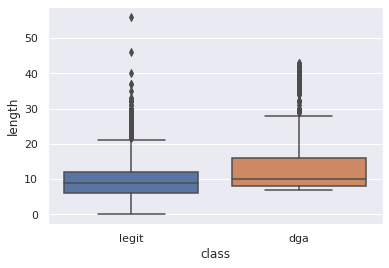

In [10]:
sns.boxplot(x=all_domains['class'],y=all_domains['length'])

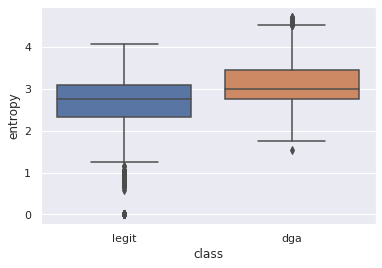

In [11]:
sns.boxplot(x=all_domains['class'],y=all_domains['entropy'])

In [12]:
X = all_domains[['length', 'entropy']]
Y = all_domains[['class']]

/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sandeepnl/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
[0.43720698 0.562793  ]


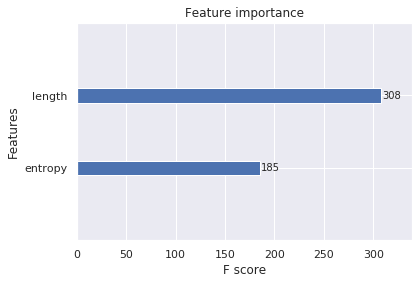

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
print(model.feature_importances_)

ax = plot_importance(model)
fig = ax.figure
plt.show(fig)

In [14]:
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.69%


In [15]:
alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [16]:
word_dataframe = pd.read_csv('words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
# word_dataframe.head(10)

In [17]:
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

In [18]:
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
[0.5662802  0.22344933 0.17495453 0.03531585]


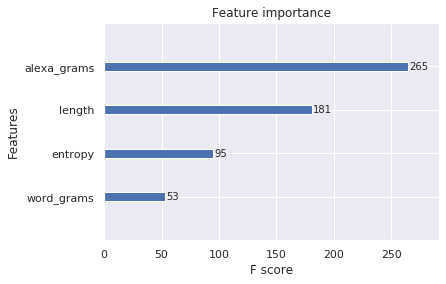

In [19]:
X = all_domains[['length', 'entropy','alexa_grams','word_grams']]
# Y = all_domains[['class']]
Y = np.array(all_domains['class'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

model = XGBClassifier()
model.fit(X_train, y_train)
print(model)
print(model.feature_importances_)

ax = plot_importance(model)
fig = ax.figure
plt.show(fig)

In [35]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
cm = confusion_matrix(y_test, y_pred, labels)
cm

Accuracy: 99.36%


array([[18235,    52],
       [   68,   453]])

In [21]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.035, n=4, Accuracy: 99.21%
Thresh=0.175, n=3, Accuracy: 99.19%
Thresh=0.223, n=2, Accuracy: 97.69%
Thresh=0.566, n=1, Accuracy: 97.58%


In [22]:
# select features using best threshold 
selection = SelectFromModel(model, threshold=0.035, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9921054327511761


In [23]:
select_X_test

array([[  8.        ,   3.        ,  19.97567528,  28.13262576],
       [ 17.        ,   3.17512314,  88.02667603, 104.06582596],
       [  4.        ,   2.        ,   2.64443859,   3.06145248],
       ...,
       [ 14.        ,   3.09306921,  56.02266145,  68.06548999],
       [ 16.        ,   3.15563906,  62.67914399,  79.0438628 ],
       [  7.        ,   2.80735492,  23.10163875,  27.95950003]])

In [24]:
def test_it(domain):
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T 
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = [len(domain), entropy(domain), _alexa_match, _dict_match]
    X_test_transformed = selection.transform(X_test)
    print(X_test_transformed)
    predicted = selection_model.predict(X_test_transformed)
    print(domain,predicted )
    #     print('%s : %s' % (domain, selection_model.predict([_X])))


# test_it('google')
# test_it('google88')
# test_it('facebook')
# test_it('1cb8a5f36f')
# test_it('pterodactylfarts')
# test_it('ptes9dro-dwacty2lfa5rrts')
# test_it('beyonce')
# test_it('bey666on4ce')
# test_it('supersexy')
# test_it('yourmomissohotinthesummertime')
test_it('04055051be412eea5a61b7da8438be3d')
# test_it('clicksecurity')


[[  8.           3.          19.97567528  28.13262576]
 [ 17.           3.17512314  88.02667603 104.06582596]
 [  4.           2.           2.64443859   3.06145248]
 ...
 [ 14.           3.09306921  56.02266145  68.06548999]
 [ 16.           3.15563906  62.67914399  79.0438628 ]
 [  7.           2.80735492  23.10163875  27.95950003]]
04055051be412eea5a61b7da8438be3d ['legit' 'legit' 'legit' ... 'legit' 'legit' 'legit']


## Try using Random Forest Algorithm.

In [40]:
import sklearn.ensemble
from sklearn.metrics import confusion_matrix
rf_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) # Trees in the forest

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[18205    63]
 [   96   444]]
Accuracy: 99.15%


Accuracy from XGBoost vs RF classification.
XG Boost Accuracy: 99.36%

array([[18235,    52],
       [   68,   453]])